## DeepCycle
### This notebook demonstrates 256 feature vector embedding with 3-class model

In [9]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

# make user code available:
import sys
from pathlib import Path
module_path = str(Path('../src').absolute())
if module_path not in sys.path:
    sys.path.insert(0, module_path)

# curated_tracks - cell tracks syncronized on 1 division events
# double_division_tracks - cell tracks syncronized on 2 division events
from const import double_division_tracks, curated_tracks, DATA_ROOT

import pickle
import numpy as np
from numpy import savez_compressed, load
import pandas as pd
import cv2
import sompy
from scipy.interpolate import interp1d, NearestNDInterpolator
from scipy.stats import pearsonr

%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase, Colorbar
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('_classic_test')

from notebook_functions import umap_transform, plot_distributions,\
                timelapse_single_frame_sync, timelapse_double_frame_sync,\
                circular_tracking, normalize_intensities, project_onto_fluo_plane

log_const = 300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
cell_df = pd.read_csv(DATA_ROOT / 'statistics_mean_std_3cls.csv')

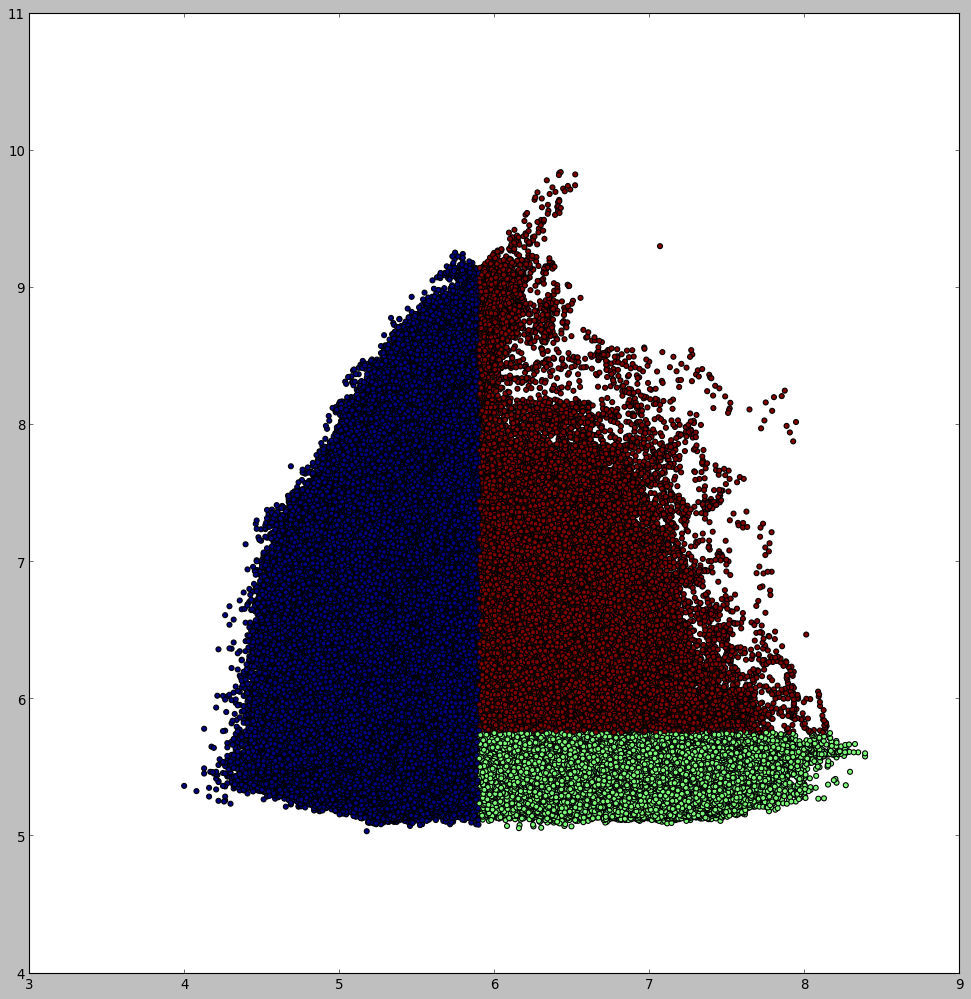

In [13]:
gr = np.log(cell_df[['GFP_20', 'Cy3_20']].values + log_const)
plt.figure(figsize=(15, 15))
plt.scatter(gr[:, 0], gr[:, 1], alpha=1, c=cell_df['cls3'])
plt.show()

In [14]:
# load cell descriptors where 
# y - true class [1..4] one hot encoded, 
# descriptors - 4-component vectors obtained on validation set; validation set is double_division_tracks, 
# intensities - 2-component intensities of the cell

with open(DATA_ROOT / 'descriptors.cls3.256.r34_256.sz48.pkl', 'rb') as f:
    y, descriptors, intensities, df_index = pickle.load(f)
    
# descriptors = np.log(descriptors + 1e-7)
intensities = np.log(intensities + log_const)
print(y.shape, descriptors.shape, intensities.shape)

(9753, 3) (9753, 256) (9753, 2)


## U-Map embedding

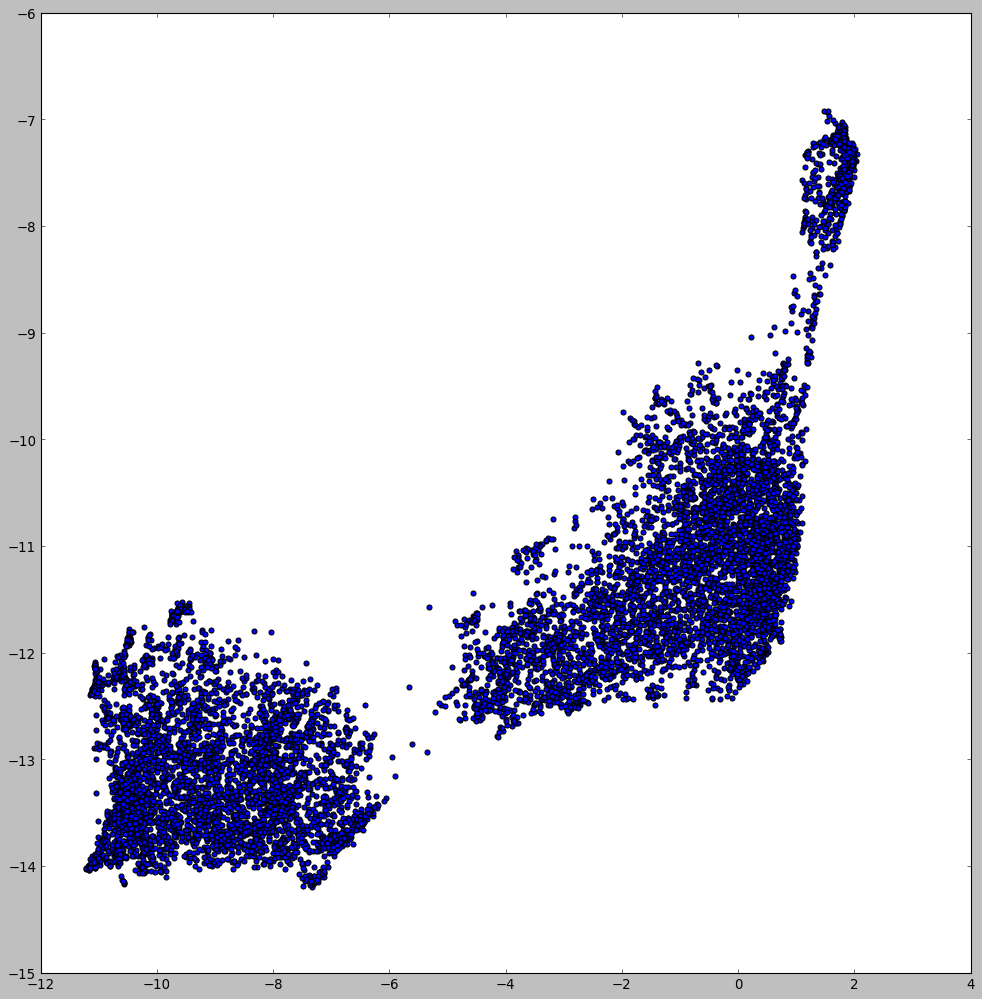

In [15]:
embeddings_preds, fit = umap_transform(descriptors, n_neighbors=500, min_dist=0.01, n_components=2, metric='correlation')

fig = plt.figure(figsize=(15, 15))
plt.scatter(embeddings_preds[:, 0], embeddings_preds[:, 1])